In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import sys, os, os.path, time
import argparse
import numpy as np
import torch
import torch.nn as nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.autograd import Variable
from TALNetModel import *
from util_in_multi_h5_unnorm import *
from util_out import *
from util_f1 import *
# from AudioResNet import resnet50
# from AST import ASTModel
from ast_models_original import ASTModel
%matplotlib inline
import subprocess
import pickle

import matplotlib.pyplot as plt
import h5py

import os


In [2]:
curr_node = socket.gethostname().split('.')[0]
batcmd=f"squeue -u billyli | grep {curr_node}"
curr_slurm = subprocess.check_output(batcmd, shell=True, text=True)
slurm_id = curr_slurm.strip().split(' ')[0]
print(slurm_id)

8464144


In [3]:
torch.cuda.is_available()
torch.cuda.device_count()

1

# VICTIM MODEL

In [4]:
parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)

parser.add_argument("--model_type", type=str, default='ast', help="the model used")
parser.add_argument("--dataset", type=str, default="audioset_s", help="the dataset used", choices=["audioset","audioset_s", "esc50", "speechcommands"])
parser.add_argument("--n_mels", type=int, default=128, help="number of mel bins")
parser.add_argument("--dataset-portion", type=str, default='full', help="balance set or full set")
parser.add_argument('--mean', default=-12.7508, type=float, help='normalizing mean')
parser.add_argument('--std', default=11.7584, type=float, help='normalizing std')

parser.add_argument("--exp-dir", type=str, default="", help="directory to dump experiments")
parser.add_argument('--lr', '--learning-rate', default="0.001", type=str, metavar='LR', help='initial learning rate')
parser.add_argument("--optim", type=str, default="adam", help="training optimizer", choices=["sgd", "adam"])
parser.add_argument('-b', '--batch-size', default=12, type=int, metavar='N', help='mini-batch size')
parser.add_argument('-w', '--num-workers', default=32, type=int, metavar='NW', help='# of workers for dataloading (default: 32)')
parser.add_argument("--n-epochs", type=int, default=1, help="number of maximum training epochs")
# not used in the formal experiments
parser.add_argument("--lr_patience", type=int, default=2, help="how many epoch to wait to reduce lr if mAP doesn't improve")

parser.add_argument("--n-print-steps", type=int, default=100, help="number of steps to print statistics")

parser.add_argument('--freqm', help='frequency mask max length', type=int, default=0)
parser.add_argument('--timem', help='time mask max length', type=int, default=0)
parser.add_argument("--mixup", type=float, default=0, help="how many (0-1) samples need to be mixup during training")
parser.add_argument("--bal", type=str, default='bal', help="use balanced sampling or not")
# the stride used in patch spliting, e.g., for patch size 16*16, a stride of 16 means no overlapping, a stride of 10 means overlap of 6.
parser.add_argument("--fstride", type=int, default=8, help="soft split freq stride, overlap=patch_size-stride")
parser.add_argument("--tstride", type=int, default=8, help="soft split time stride, overlap=patch_size-stride")
parser.add_argument('--imagenet_pretrain', help='if use ImageNet pretrained audio spectrogram transformer model', type=bool, default='True')
parser.add_argument('--audioset_pretrain', help='if use ImageNet and audioset pretrained audio spectrogram transformer model', type=bool, default='False')

parser.add_argument('--embedding_size', type = int, default = 1024) # this is the embedding size after a pooling layer
                                                                    # after a non-pooling layer, the embeddings size will be twice this much
parser.add_argument('--n_conv_layers', type = int, default = 10)
parser.add_argument('--n_trans_layers', type = int, default = 2)
parser.add_argument('--kernel_size', type = str, default = '3')     # 'n' or 'nxm'
parser.add_argument('--n_pool_layers', type = int, default = 5)     # the pooling layers will be inserted uniformly into the conv layers
                                                                    # the should be at least 2 and at most 6 pooling layers
                                                                    # the first two pooling layers will have stride (2,2); later ones will have stride (1,2)
parser.add_argument('--batch_norm', type = bool, default = True)
parser.add_argument('--dropout', type = float, default = 0.0)
parser.add_argument('--pooling', type = str, default = 'att', choices = ['max', 'ave', 'lin', 'exp', 'att', 'h-att', 'all'])
parser.add_argument('--continue_from_ckpt', type = str, default = None)
parser.add_argument('--addpos', type = bool, default = True)
parser.add_argument('--transformer_dropout', type = float, default = 0.75)
parser.add_argument('--suffix', type=str, default='')


_StoreAction(option_strings=['--suffix'], dest='suffix', nargs=None, const=None, default='', type=<class 'str'>, choices=None, help=None, metavar=None)

### AST 64x400 best model

In [5]:
args = parser.parse_args(args=['--model_type=TAL','--dataset=audioset_s','--n_mels=64', '--mean=-29.072655','--std=40.71728',
                               '--lr=1.6e-3','--batch-size=400','--n-epochs=10',
                               '--freqm=12','--timem=75','--mixup=0.3',
                               '--transformer_dropout=0.25','--addpos=True','--pooling=att',
                               '--embedding_size=1024',
                               '--imagenet_pretrain=True','--suffix=big_feat_embed1024-40.6'])
if 'x' not in args.kernel_size:
    args.kernel_size = args.kernel_size + 'x' + args.kernel_size
args.kernel_size = tuple(int(x) for x in args.kernel_size.split('x'))
args.target_length=400
exp_id = f"{args.model_type}-{args.dataset}-{args.dataset_portion}-p{args.imagenet_pretrain}-b{args.batch_size}-lr{args.lr}\
-fm{args.freqm}-tm{args.timem}-mix{args.mixup}-m{args.mean}-std{args.std}-epoch{args.n_epochs}\
-conv{args.n_conv_layers}-pool{args.n_pool_layers}-trans{args.n_trans_layers}-{args.suffix}"
print(exp_id)
WORKSPACE = '/jet/home/billyli/data_folder/AllaboutAudioSet_hack/egs/audioset/exp'
MODEL_FILE = os.path.join(WORKSPACE, exp_id, 'models', 'audio_model.10.pth')

TAL-audioset_s-full-pTrue-b400-lr1.6e-3-fm12-tm75-mix0.3-m-29.072655-std40.71728-epoch10-conv10-pool5-trans2-big_feat_embed1024-40.6


### AST 128x1024 best model

In [6]:
# args = parser.parse_args(args=['--model_type=AST','--dataset=audioset','--n_mels=128', '--mean=-3.6788461','--std=4.3739743',
#                                '--lr=1e-5','--batch-size=20','--n-epochs=10','--fstride=10','--tstride=10',
#                                '--freqm=36','--timem=192','--mixup=0.3',
#                                '--imagenet_pretrain=True','--suffix=ast_challenge-43.0'])
# args.target_length=1024
# exp_id = f"{args.dataset}-{args.dataset_portion}-f{args.fstride}-t{args.tstride}-p{args.imagenet_pretrain}-b{args.batch_size}-lr{args.lr}\
# -fm{args.freqm}-tm{args.timem}-mix{args.mixup}-m{args.mean}-std{args.std}-epoch{args.n_epochs}-{args.suffix}"
# print(exp_id)
# WORKSPACE = '/jet/home/billyli/data_folder/AllaboutAudioSet_hack/egs/audioset/exp'
# MODEL_FILE = os.path.join(WORKSPACE, exp_id, 'models', 'audio_model.3.pth')

In [7]:
print(MODEL_FILE)

/jet/home/billyli/data_folder/AllaboutAudioSet_hack/egs/audioset/exp/TAL-audioset_s-full-pTrue-b400-lr1.6e-3-fm12-tm75-mix0.3-m-29.072655-std40.71728-epoch10-conv10-pool5-trans2-big_feat_embed1024-40.6/models/audio_model.10.pth


In [8]:
args

Namespace(addpos=True, audioset_pretrain=True, bal='bal', batch_norm=True, batch_size=400, continue_from_ckpt=None, dataset='audioset_s', dataset_portion='full', dropout=0.0, embedding_size=1024, exp_dir='', freqm=12, fstride=8, imagenet_pretrain=True, kernel_size=(3, 3), lr='1.6e-3', lr_patience=2, mean=-29.072655, mixup=0.3, model_type='TAL', n_conv_layers=10, n_epochs=10, n_mels=64, n_pool_layers=5, n_print_steps=100, n_trans_layers=2, num_workers=32, optim='adam', pooling='att', std=40.71728, suffix='big_feat_embed1024-40.6', target_length=400, timem=75, transformer_dropout=0.25, tstride=8)

In [9]:
# Load model
#model = Net(args).cuda()
if args.model_type == 'TAL':
    model = TALNet(args).cuda()
elif args.model_type == 'TALtrans':
    model = TransformerEncoder(args).cuda()
elif args.model_type == 'TAL-new':
    model = NewNet(args).cuda()
elif args.model_type == 'Trans':
    model = Transformer(args).cuda()
elif args.model_type == 'resnet':
    model = resnet50().cuda()
elif args.model_type == 'MMT':
    model = MMTEncoder(args).cuda()
elif args.model_type == 'VM':
    model = videoModel(args).cuda()
elif args.model_type == 'MMTLF':
    model = LateFusion(args).cuda()
elif args.model_type == 'AST':
    model = ASTModel(label_dim=527, fstride=args.fstride, tstride=args.tstride, input_fdim=args.n_mels, input_tdim=args.target_length, imagenet_pretrain=args.imagenet_pretrain, audioset_pretrain=False).cuda()
else:
    print ('model type not recognized')
    exit(0)


/ocean/projects/iri120008p/billyli/DayLongAudio/audioset_py3/AudioSetDoneRight/TALNetModel.py:25: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.conv.weight)


In [10]:
optimizer = Adam(model.parameters())


In [11]:
prev_ckpt = torch.load(MODEL_FILE)
# start_ckpt = prev_ckpt['epoch']
# scheduler.load_state_dict(prev_ckpt['scheduler'])
# model = nn.DataParallel(model)
temp = {}
for key, val in prev_ckpt.items():
    key = key.replace('module.','')
    temp[key] = val
model.load_state_dict(temp)
# optimizer.load_state_dict(prev_ckpt['optimizer'])
# write_log('Loading model from %s' % args.continue_from_ckpt)
model.eval()

TALNet(
  (conv): ModuleList(
    (0): ConvBlock(
      (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ConvBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ConvBlock(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): ConvBlock(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_runni

In [12]:
N_CLASSES = 527
N_WORKERS = 6
local = f"/local/slurm-{slurm_id}/local/audio"
if args.dataset == 'audioset_s':
    hf_val_eval_path = os.path.join(local, 'data_64_400_again.h5')
elif args.dataset == 'audioset':
    hf_val_eval_path = os.path.join(local, 'data_128_1024_again.h5')
# hf_val_eval_path = os.path.join(local, 'data_128_1024_strong_cleaned.h5')
mu_val=args.mean
sigma_val=args.std
                            
def bulk_load2(file_path, mu, sigma):
    hf_val_eval = h5py.File(file_path, 'r')
    feat_a = (hf_val_eval['feat_a'][:]*2-mu)/(2 * sigma)
    labels = hf_val_eval['labels'][:]
    hf_val_eval.close()
    return feat_a.astype('float32'), labels.astype('bool')

gas_eval_x1, gas_eval_y = bulk_load2(hf_val_eval_path, mu_val, sigma_val)

In [13]:
gas_eval_x1.shape, gas_eval_y.shape, mu_val, sigma_val

((20123, 400, 64), (20123, 527), -29.072655, 40.71728)

# Inference

In [14]:
result = []
batch_size =100
x = gas_eval_x1 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
#         output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]


total num of batches during testing 202


In [15]:
print(result[0].shape)

(20123, 527)


In [16]:
gas_eval_global_prob_multi = result[0]

In [17]:
# print(gas_eval_global_prob_multi.shape)

In [18]:
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)

Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------


In [19]:
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

0.40592912025981726 0.9715888453479389 2.6936174492835847
 Average | 0.406 | 0.972 | 2.694 
---------+-------+-------+-------
       0 | 0.786 | 0.933 | 2.114 
       1 | 0.058 | 0.835 | 1.377 
       2 | 0.091 | 0.945 | 2.259 
       3 | 0.393 | 0.970 | 2.656 
       4 | 0.206 | 0.977 | 2.818 
       5 | 0.064 | 0.945 | 2.256 
       6 | 0.547 | 0.997 | 3.846 
       7 | 0.438 | 0.982 | 2.970 
       8 | 0.171 | 0.952 | 2.348 
       9 | 0.158 | 0.947 | 2.281 
      10 | 0.225 | 0.971 | 2.674 
      11 | 0.218 | 0.978 | 2.846 
      12 | 0.845 | 0.999 | 4.597 
      13 | 0.521 | 0.996 | 3.730 
      14 | 0.217 | 0.979 | 2.875 
      15 | 0.779 | 0.999 | 4.376 
      16 | 0.432 | 0.983 | 3.014 
      17 | 0.628 | 0.996 | 3.735 
      18 | 0.232 | 0.983 | 3.013 
      19 | 0.246 | 0.983 | 2.992 
      20 | 0.373 | 0.990 | 3.315 
      21 | 0.226 | 0.980 | 2.903 
      22 | 0.497 | 0.987 | 3.169 
      23 | 0.497 | 0.993 | 3.494 
      24 | 0.246 | 0.968 | 2.628 
      25 | 0.119 | 0.928

# Occlusion

In [20]:
gas_eval_x1_origin = gas_eval_x1

In [21]:
min_val = numpy.min(gas_eval_x1)
max_val = numpy.max(gas_eval_x1)
mean_val = numpy.mean(gas_eval_x1)
std_val = numpy.std(gas_eval_x1)
print(min_val, max_val, mean_val, std_val)

-2.0989532 1.3362997 -0.123829365 0.5745247


In [22]:
gas_eval_x1.shape

(20123, 400, 64)

<h>Occ 4s</h>

In [23]:
new_gas_eval = []
time_frame = 400
step = 80
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

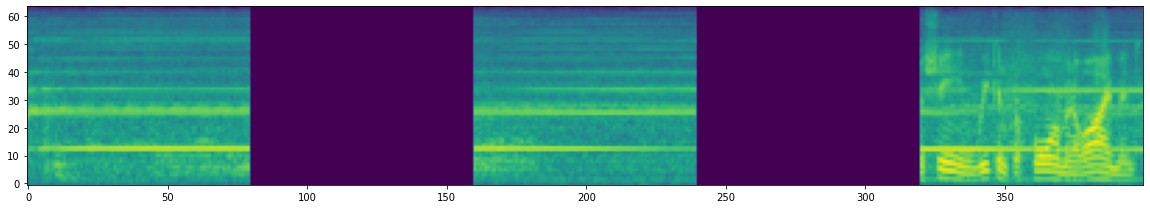

In [24]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [25]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.3566282640210728 0.9622322121736988 2.5133383121906645
 Average | 0.357 | 0.962 | 2.513 
---------+-------+-------+-------
       0 | 0.754 | 0.916 | 1.945 
       1 | 0.042 | 0.822 | 1.303 
       2 | 0.100 | 0.941 | 2.211 
       3 | 0.384 | 0.956 | 2.417 
       4 | 0.138 | 0.965 | 2.561 
       5 | 0.056 | 0.943 | 2.238 
       6 | 0.413 | 0.991 | 3.370 
       7 | 0.357 | 0.970 | 2.662 
       8 | 0.158 | 0.941 | 2.209 
       9 | 0.112 | 0.938 | 2.181 
      10 | 0.130 | 0.959 | 2.465 
      11 | 0.241 | 0.978 | 2.839 
      12 | 0.855 | 0.999 | 4.575 
      13 | 0.480 | 0.993 | 3.487 
      14 | 0.202 | 0.966 | 2.585 
      15 | 0.735 | 0.998 | 4.033 
      16 | 0.373 | 0.976 | 2.806 
      17 | 0.605 | 0.993 | 3.476 
      18 | 0.211 | 0.976 | 2.796 
      19 | 0.194 | 0.972 | 2.705 
      20 | 0.240 | 0.984 | 3.035 
      21 | 0.162 | 0

<h>First 5s</h>

In [26]:
new_gas_eval = []

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    record.mask[:200]=True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

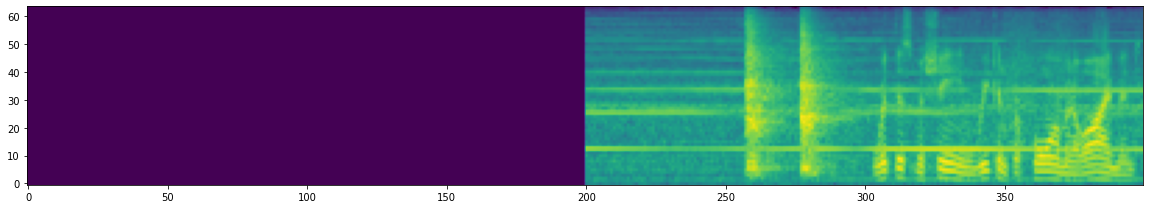

In [27]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [28]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.3262124568260788 0.9469837670104483 2.2857737541418803
 Average | 0.326 | 0.947 | 2.286 
---------+-------+-------+-------
       0 | 0.701 | 0.879 | 1.652 
       1 | 0.055 | 0.811 | 1.247 
       2 | 0.082 | 0.924 | 2.025 
       3 | 0.334 | 0.935 | 2.144 
       4 | 0.116 | 0.941 | 2.212 
       5 | 0.033 | 0.924 | 2.025 
       6 | 0.389 | 0.970 | 2.658 
       7 | 0.254 | 0.980 | 2.895 
       8 | 0.131 | 0.933 | 2.121 
       9 | 0.119 | 0.936 | 2.154 
      10 | 0.117 | 0.944 | 2.252 
      11 | 0.128 | 0.953 | 2.370 
      12 | 0.754 | 0.995 | 3.625 
      13 | 0.458 | 0.992 | 3.431 
      14 | 0.173 | 0.964 | 2.539 
      15 | 0.593 | 0.962 | 2.511 
      16 | 0.361 | 0.973 | 2.720 
      17 | 0.339 | 0.981 | 2.944 
      18 | 0.153 | 0.955 | 2.391 
      19 | 0.199 | 0.944 | 2.253 
      20 | 0.308 | 0.982 | 2.965 
      21 | 0.190 | 0

<h>mid 5s</h>

In [29]:
new_gas_eval = []

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    record.mask[100:300]=True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

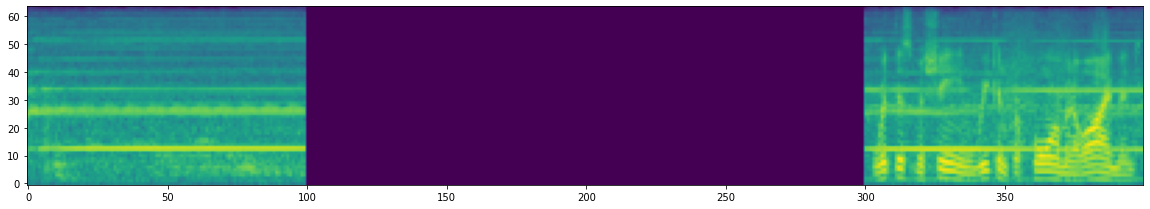

In [30]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [31]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.338552508159464 0.9554568222800236 2.404498223100318
 Average | 0.339 | 0.955 | 2.404 
---------+-------+-------+-------
       0 | 0.735 | 0.902 | 1.832 
       1 | 0.036 | 0.811 | 1.245 
       2 | 0.081 | 0.946 | 2.275 
       3 | 0.361 | 0.945 | 2.266 
       4 | 0.118 | 0.960 | 2.477 
       5 | 0.062 | 0.935 | 2.143 
       6 | 0.368 | 0.983 | 2.983 
       7 | 0.386 | 0.970 | 2.670 
       8 | 0.143 | 0.943 | 2.233 
       9 | 0.077 | 0.932 | 2.105 
      10 | 0.128 | 0.960 | 2.475 
      11 | 0.176 | 0.965 | 2.568 
      12 | 0.787 | 0.999 | 4.357 
      13 | 0.467 | 0.995 | 3.629 
      14 | 0.115 | 0.951 | 2.339 
      15 | 0.736 | 0.985 | 3.072 
      16 | 0.357 | 0.970 | 2.654 
      17 | 0.506 | 0.986 | 3.111 
      18 | 0.192 | 0.966 | 2.581 
      19 | 0.240 | 0.967 | 2.596 
      20 | 0.324 | 0.983 | 2.985 
      21 | 0.152 | 0.9

<h>mid 5s</h>

In [32]:
new_gas_eval = []

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    record.mask[200:400]=True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

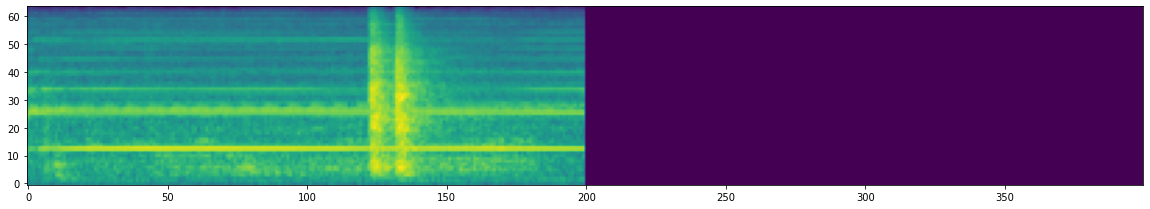

In [33]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [34]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.3292982731192319 0.9454790950178825 2.266298211859662
 Average | 0.329 | 0.945 | 2.266 
---------+-------+-------+-------
       0 | 0.716 | 0.881 | 1.670 
       1 | 0.027 | 0.800 | 1.191 
       2 | 0.071 | 0.916 | 1.948 
       3 | 0.317 | 0.944 | 2.252 
       4 | 0.104 | 0.944 | 2.249 
       5 | 0.051 | 0.918 | 1.966 
       6 | 0.421 | 0.981 | 2.945 
       7 | 0.285 | 0.973 | 2.734 
       8 | 0.140 | 0.929 | 2.073 
       9 | 0.111 | 0.919 | 1.976 
      10 | 0.153 | 0.941 | 2.211 
      11 | 0.142 | 0.970 | 2.670 
      12 | 0.784 | 0.999 | 4.329 
      13 | 0.399 | 0.960 | 2.476 
      14 | 0.174 | 0.932 | 2.110 
      15 | 0.757 | 0.992 | 3.434 
      16 | 0.330 | 0.960 | 2.470 
      17 | 0.596 | 0.976 | 2.797 
      18 | 0.160 | 0.964 | 2.551 
      19 | 0.192 | 0.949 | 2.307 
      20 | 0.276 | 0.953 | 2.367 
      21 | 0.210 | 0.

<h>Every 1s</h1>

In [35]:
new_gas_eval = []
time_frame = 400
step = 40
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

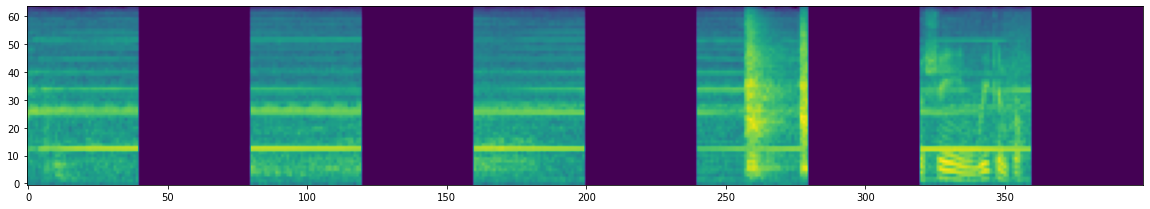

In [36]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [37]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.3083746107092658 0.9503439010539501 2.3309029256820413
 Average | 0.308 | 0.950 | 2.331 
---------+-------+-------+-------
       0 | 0.726 | 0.901 | 1.822 
       1 | 0.041 | 0.818 | 1.284 
       2 | 0.080 | 0.926 | 2.047 
       3 | 0.324 | 0.963 | 2.522 
       4 | 0.117 | 0.953 | 2.373 
       5 | 0.054 | 0.931 | 2.095 
       6 | 0.403 | 0.986 | 3.113 
       7 | 0.285 | 0.973 | 2.732 
       8 | 0.144 | 0.923 | 2.018 
       9 | 0.109 | 0.939 | 2.187 
      10 | 0.121 | 0.952 | 2.350 
      11 | 0.128 | 0.947 | 2.291 
      12 | 0.737 | 0.999 | 4.201 
      13 | 0.356 | 0.992 | 3.392 
      14 | 0.117 | 0.941 | 2.211 
      15 | 0.743 | 0.994 | 3.573 
      16 | 0.378 | 0.976 | 2.809 
      17 | 0.509 | 0.990 | 3.288 
      18 | 0.177 | 0.962 | 2.505 
      19 | 0.175 | 0.961 | 2.498 
      20 | 0.220 | 0.970 | 2.668 
      21 | 0.148 | 0

<h>Every 0.5s</h1>

In [38]:
new_gas_eval = []
time_frame = 400
step = 20
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

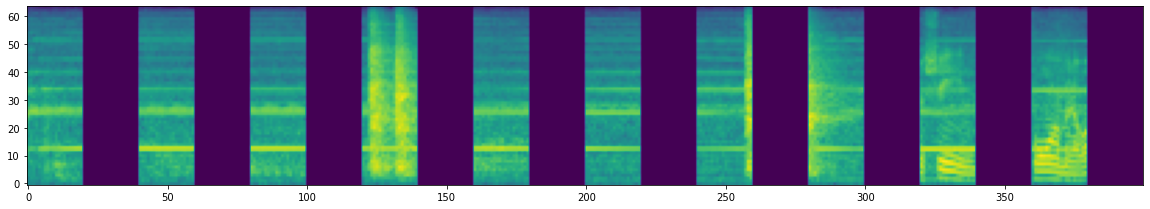

In [39]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [40]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.21322476549766792 0.925135812922305 2.037162710675786
 Average | 0.213 | 0.925 | 2.037 
---------+-------+-------+-------
       0 | 0.689 | 0.885 | 1.700 
       1 | 0.029 | 0.823 | 1.311 
       2 | 0.059 | 0.934 | 2.130 
       3 | 0.298 | 0.947 | 2.281 
       4 | 0.076 | 0.947 | 2.292 
       5 | 0.053 | 0.927 | 2.058 
       6 | 0.324 | 0.985 | 3.079 
       7 | 0.185 | 0.969 | 2.646 
       8 | 0.095 | 0.908 | 1.880 
       9 | 0.017 | 0.841 | 1.411 
      10 | 0.080 | 0.919 | 1.978 
      11 | 0.041 | 0.902 | 1.826 
      12 | 0.582 | 0.995 | 3.646 
      13 | 0.219 | 0.982 | 2.967 
      14 | 0.077 | 0.951 | 2.334 
      15 | 0.603 | 0.986 | 3.121 
      16 | 0.329 | 0.964 | 2.548 
      17 | 0.404 | 0.987 | 3.138 
      18 | 0.141 | 0.954 | 2.389 
      19 | 0.107 | 0.939 | 2.192 
      20 | 0.161 | 0.976 | 2.808 
      21 | 0.075 | 0.

<h>Every 0.25s</h1>

In [41]:
new_gas_eval = []
time_frame = 400
step = 10
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

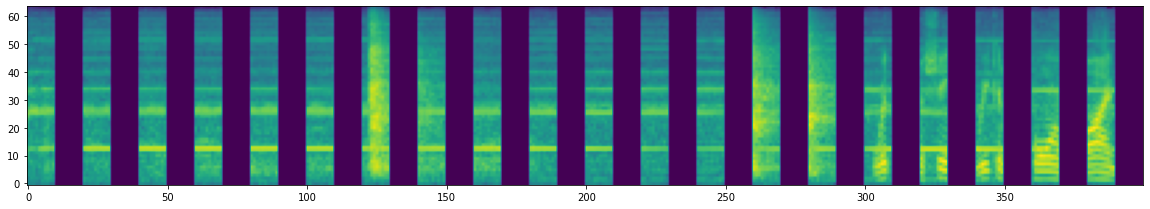

In [42]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [43]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.06678724856792337 0.820814477124363 1.298917628085824
 Average | 0.067 | 0.821 | 1.299 
---------+-------+-------+-------
       0 | 0.605 | 0.839 | 1.401 
       1 | 0.011 | 0.722 | 0.831 
       2 | 0.048 | 0.902 | 1.827 
       3 | 0.162 | 0.929 | 2.074 
       4 | 0.053 | 0.935 | 2.139 
       5 | 0.023 | 0.897 | 1.790 
       6 | 0.090 | 0.970 | 2.662 
       7 | 0.046 | 0.923 | 2.017 
       8 | 0.048 | 0.816 | 1.272 
       9 | 0.007 | 0.658 | 0.576 
      10 | 0.010 | 0.795 | 1.166 
      11 | 0.005 | 0.710 | 0.784 
      12 | 0.163 | 0.932 | 2.107 
      13 | 0.075 | 0.930 | 2.084 
      14 | 0.031 | 0.876 | 1.631 
      15 | 0.420 | 0.967 | 2.591 
      16 | 0.125 | 0.934 | 2.127 
      17 | 0.113 | 0.953 | 2.366 
      18 | 0.055 | 0.901 | 1.820 
      19 | 0.047 | 0.923 | 2.012 
      20 | 0.079 | 0.938 | 2.178 
      21 | 0.046 | 0.

<h>Every 0.25s</h1>

In [44]:
new_gas_eval = []
time_frame = 400
step = 5
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

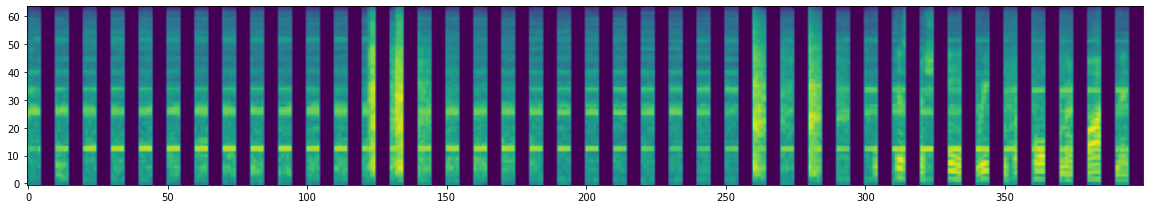

In [45]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [46]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.018165805853884363 0.6664723172129221 0.6083845572643352
 Average | 0.018 | 0.666 | 0.608 
---------+-------+-------+-------
       0 | 0.470 | 0.741 | 0.913 
       1 | 0.004 | 0.571 | 0.254 
       2 | 0.015 | 0.774 | 1.062 
       3 | 0.061 | 0.790 | 1.139 
       4 | 0.017 | 0.823 | 1.312 
       5 | 0.014 | 0.671 | 0.627 
       6 | 0.005 | 0.670 | 0.624 
       7 | 0.010 | 0.789 | 1.135 
       8 | 0.004 | 0.591 | 0.325 
       9 | 0.004 | 0.500 |-0.001 
      10 | 0.009 | 0.622 | 0.440 
      11 | 0.002 | 0.471 |-0.103 
      12 | 0.016 | 0.659 | 0.580 
      13 | 0.020 | 0.759 | 0.994 
      14 | 0.004 | 0.639 | 0.503 
      15 | 0.201 | 0.958 | 2.441 
      16 | 0.009 | 0.630 | 0.468 
      17 | 0.005 | 0.661 | 0.589 
      18 | 0.006 | 0.724 | 0.842 
      19 | 0.006 | 0.532 | 0.113 
      20 | 0.003 | 0.466 |-0.121 
      21 | 0.007 |

<h>concat 0.125s</h>

In [47]:
new_gas_eval = []
time_frame = 400
step = 5
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.compressed().reshape(half,n_mel)
    fill_matrix = numpy.full((half,n_mel), silence_val)
#     print('shape', fill_matrix.shape)
    mask_record = numpy.vstack((mask_record, fill_matrix))
#     record.mask[100:300]=True
#     mask_record = record[~record.mask]
#     print(mask_record.shape)
#     mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

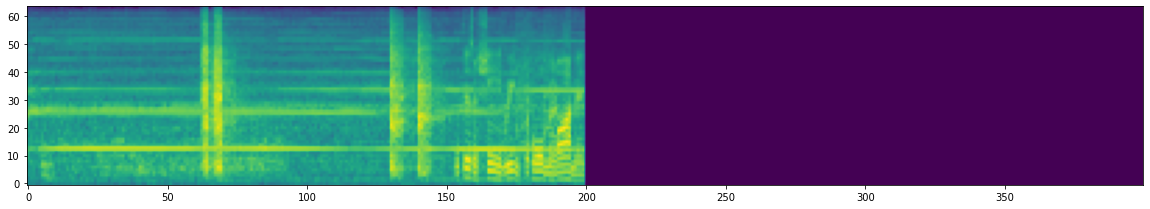

In [48]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [49]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.2960135806914452 0.9491683007810764 2.3148447579797233
 Average | 0.296 | 0.949 | 2.315 
---------+-------+-------+-------
       0 | 0.721 | 0.905 | 1.850 
       1 | 0.038 | 0.834 | 1.372 
       2 | 0.070 | 0.927 | 2.053 
       3 | 0.282 | 0.958 | 2.437 
       4 | 0.106 | 0.967 | 2.597 
       5 | 0.039 | 0.932 | 2.113 
       6 | 0.255 | 0.983 | 2.993 
       7 | 0.350 | 0.980 | 2.893 
       8 | 0.122 | 0.934 | 2.132 
       9 | 0.079 | 0.912 | 1.912 
      10 | 0.088 | 0.949 | 2.308 
      11 | 0.153 | 0.950 | 2.320 
      12 | 0.700 | 0.996 | 3.805 
      13 | 0.363 | 0.994 | 3.515 
      14 | 0.130 | 0.962 | 2.517 
      15 | 0.636 | 0.993 | 3.459 
      16 | 0.358 | 0.974 | 2.752 
      17 | 0.357 | 0.980 | 2.919 
      18 | 0.109 | 0.969 | 2.641 
      19 | 0.167 | 0.952 | 2.350 
      20 | 0.312 | 0.980 | 2.916 
      21 | 0.176 | 0

<h>concat 0.25s</h>

In [50]:
new_gas_eval = []
time_frame = 400
step = 10
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.compressed().reshape(half,n_mel)
    fill_matrix = numpy.full((half,n_mel), silence_val)
#     print('shape', fill_matrix.shape)
    mask_record = numpy.vstack((mask_record, fill_matrix))
#     record.mask[100:300]=True
#     mask_record = record[~record.mask]
#     print(mask_record.shape)
#     mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

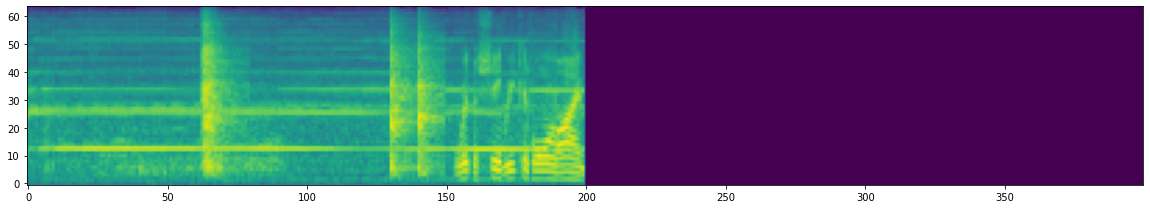

In [51]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [52]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.31363595944160094 0.9541700168432821 2.3853619973779008
 Average | 0.314 | 0.954 | 2.385 
---------+-------+-------+-------
       0 | 0.734 | 0.909 | 1.890 
       1 | 0.047 | 0.807 | 1.225 
       2 | 0.063 | 0.930 | 2.085 
       3 | 0.329 | 0.963 | 2.529 
       4 | 0.147 | 0.973 | 2.727 
       5 | 0.061 | 0.954 | 2.378 
       6 | 0.275 | 0.989 | 3.227 
       7 | 0.295 | 0.985 | 3.085 
       8 | 0.148 | 0.929 | 2.072 
       9 | 0.105 | 0.931 | 2.096 
      10 | 0.081 | 0.949 | 2.307 
      11 | 0.127 | 0.952 | 2.347 
      12 | 0.771 | 0.999 | 4.343 
      13 | 0.475 | 0.992 | 3.435 
      14 | 0.141 | 0.965 | 2.562 
      15 | 0.740 | 0.996 | 3.800 
      16 | 0.372 | 0.974 | 2.759 
      17 | 0.288 | 0.983 | 3.003 
      18 | 0.152 | 0.977 | 2.831 
      19 | 0.211 | 0.973 | 2.717 
      20 | 0.317 | 0.985 | 3.081 
      21 | 0.169 | 

<h>concat 0.5s</h>

In [53]:
new_gas_eval = []
time_frame = 400
step = 20
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.compressed().reshape(half,n_mel)
    fill_matrix = numpy.full((half,n_mel), silence_val)
#     print('shape', fill_matrix.shape)
    mask_record = numpy.vstack((mask_record, fill_matrix))
#     record.mask[100:300]=True
#     mask_record = record[~record.mask]
#     print(mask_record.shape)
#     mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

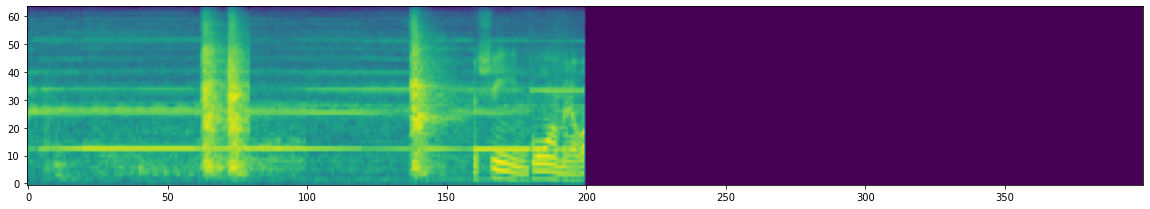

In [54]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [55]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.33364578992707283 0.9566371349583336 2.4224464413571813
 Average | 0.334 | 0.957 | 2.422 
---------+-------+-------+-------
       0 | 0.741 | 0.910 | 1.892 
       1 | 0.055 | 0.835 | 1.377 
       2 | 0.088 | 0.938 | 2.180 
       3 | 0.324 | 0.957 | 2.435 
       4 | 0.133 | 0.966 | 2.587 
       5 | 0.070 | 0.948 | 2.303 
       6 | 0.346 | 0.993 | 3.468 
       7 | 0.336 | 0.986 | 3.108 
       8 | 0.143 | 0.935 | 2.145 
       9 | 0.113 | 0.930 | 2.092 
      10 | 0.107 | 0.952 | 2.348 
      11 | 0.112 | 0.946 | 2.275 
      12 | 0.764 | 0.998 | 4.143 
      13 | 0.462 | 0.993 | 3.468 
      14 | 0.151 | 0.969 | 2.647 
      15 | 0.738 | 0.997 | 3.856 
      16 | 0.392 | 0.979 | 2.873 
      17 | 0.463 | 0.992 | 3.393 
      18 | 0.228 | 0.964 | 2.551 
      19 | 0.208 | 0.966 | 2.574 
      20 | 0.289 | 0.984 | 3.024 
      21 | 0.145 | 

<h>concat 1s</h>

In [56]:
new_gas_eval = []
time_frame = 400
step = 40
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.compressed().reshape(half,n_mel)
    fill_matrix = numpy.full((half,n_mel), silence_val)
#     print('shape', fill_matrix.shape)
    mask_record = numpy.vstack((mask_record, fill_matrix))
#     record.mask[100:300]=True
#     mask_record = record[~record.mask]
#     print(mask_record.shape)
#     mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

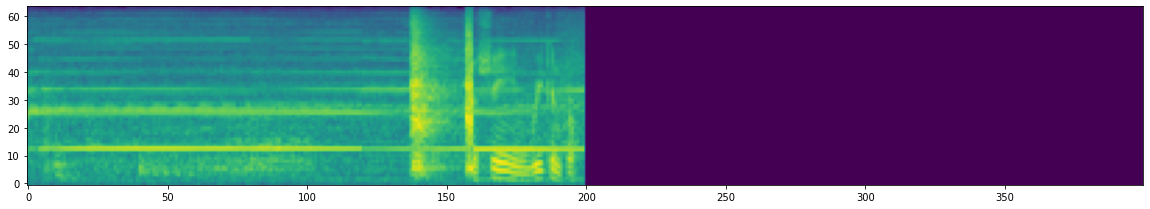

In [57]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [58]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.33884195623142116 0.9567006754463412 2.423423789607888
 Average | 0.339 | 0.957 | 2.423 
---------+-------+-------+-------
       0 | 0.742 | 0.909 | 1.885 
       1 | 0.047 | 0.813 | 1.259 
       2 | 0.087 | 0.930 | 2.084 
       3 | 0.341 | 0.963 | 2.527 
       4 | 0.127 | 0.967 | 2.608 
       5 | 0.064 | 0.945 | 2.256 
       6 | 0.364 | 0.988 | 3.205 
       7 | 0.331 | 0.978 | 2.836 
       8 | 0.149 | 0.927 | 2.058 
       9 | 0.109 | 0.936 | 2.152 
      10 | 0.105 | 0.951 | 2.338 
      11 | 0.167 | 0.953 | 2.362 
      12 | 0.785 | 0.999 | 4.459 
      13 | 0.450 | 0.992 | 3.429 
      14 | 0.170 | 0.952 | 2.355 
      15 | 0.750 | 0.992 | 3.413 
      16 | 0.390 | 0.978 | 2.856 
      17 | 0.517 | 0.994 | 3.522 
      18 | 0.172 | 0.966 | 2.589 
      19 | 0.186 | 0.972 | 2.708 
      20 | 0.295 | 0.980 | 2.895 
      21 | 0.164 | 0

# White noise 2D

In [20]:
import numpy as np
new_gas_eval = []
for record in gas_eval_x1:
    record += np.random.normal(0, 0.1, (400,64))
    new_gas_eval.append(record)
new_gas_eval = numpy.array(new_gas_eval)

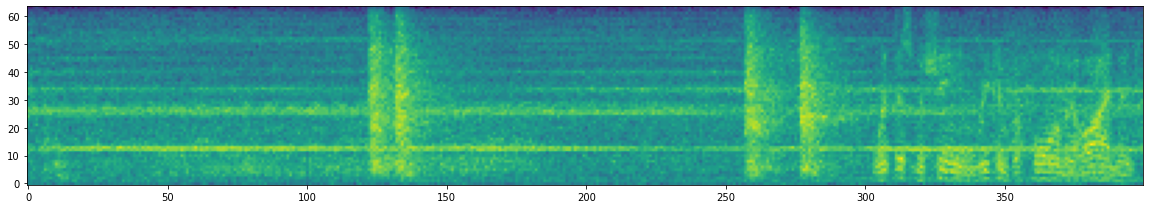

In [21]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [22]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.04899622400217548 0.7383514319239728 0.9026518308961681
 Average | 0.049 | 0.738 | 0.903 
---------+-------+-------+-------
       0 | 0.573 | 0.815 | 1.266 
       1 | 0.008 | 0.731 | 0.870 
       2 | 0.021 | 0.854 | 1.491 
       3 | 0.152 | 0.847 | 1.449 
       4 | 0.069 | 0.925 | 2.039 
       5 | 0.083 | 0.908 | 1.876 
       6 | 0.065 | 0.833 | 1.368 
       7 | 0.199 | 0.922 | 2.007 
       8 | 0.013 | 0.680 | 0.663 
       9 | 0.004 | 0.601 | 0.363 
      10 | 0.007 | 0.633 | 0.479 
      11 | 0.003 | 0.480 |-0.070 
      12 | 0.058 | 0.832 | 1.359 
      13 | 0.014 | 0.759 | 0.993 
      14 | 0.063 | 0.901 | 1.819 
      15 | 0.118 | 0.897 | 1.786 
      16 | 0.117 | 0.909 | 1.888 
      17 | 0.197 | 0.917 | 1.963 
      18 | 0.038 | 0.841 | 1.412 
      19 | 0.052 | 0.860 | 1.531 
      20 | 0.155 | 0.867 | 1.574 
      21 | 0.022 | 

# Adversarial Perturbation (infinity)

In [31]:
from torch.cuda.amp import autocast,GradScaler

In [32]:
import numpy as np
np.unique(gas_eval_y.astype('float16'))
print(np.min(gas_eval_x1), np.max(gas_eval_x1))

-2.635846 1.6238698


In [33]:
pgd_dataset = torch.utils.data.TensorDataset(torch.from_numpy(gas_eval_x1[:]), torch.from_numpy(gas_eval_y[:].astype('float32')))
pgd_dataloader = torch.utils.data.DataLoader(pgd_dataset, batch_size=50, shuffle=True)

In [40]:
def pgd(model, dataloader, delta_global, num_steps, step_size, step_norm, eps, eps_norm, x_min, x_max, delta_min, delta_max, y_target=None):
    """Performs the projected gradient descent attack on a batch of images."""
    model.cuda().train()
    targeted = y_target is not None
    criterion = nn.BCELoss().cuda()
    loss_global = 0
    for epoch in range(num_steps):
        torch.cuda.empty_cache()
        loss_global = 0
        dataiter = iter(dataloader)
        for step, (feat_a, y) in enumerate(dataiter):
            feat_a = feat_a.cuda()
            
            x_adv_1 = feat_a + delta_global #.to(x.device)
            x_adv_1 = x_adv_1.clamp(x_min, x_max)
            # only video
           
            N_1, T_1, V_1 = x_adv_1.shape
#             print(N_1,T_1,V_1)

            #######   data loaded ###################
            _x_adv_1 = x_adv_1.clone().detach().requires_grad_(True).cuda()

            #######   get gradient #################
#             with torch.no_grad():
#             model.train()# double check

            out = model(_x_adv_1)
#                 print(out)
#                 out = torch.sigmoid(out)
#                 epsilon = 1e-7
#                 out = torch.clamp(out, epsilon, 1. - epsilon)
#                 temp_out = out.clamp(0,1).cuda()
#                 print(temp_out.shape, y.shape, temp_out.max(), temp_out.min())
#                 print(temp_out.shape, y.shape)

            loss = criterion(out, y.to('cuda', non_blocking=True))
            loss_global += loss.item()
#                 print(loss.item(), loss_global)
            loss.backward()
#             break
            ########   updated _x_adv ###############
            with torch.no_grad():
            # Force the gradient step to be a fixed size in a certain norm
                if step_norm == 'inf':
                    gradients = _x_adv_1.grad.sign() * step_size
                else:
                    # The grad is normalized here.
                    # gradients = _x_adv.grad 
                    # Only normalize w.r.t. to feats at a timestep
                    gradients = _x_adv_1.grad/_x_adv_1.grad.norm(step_norm, dim=-1).view(-1, T_1, 1)
                    gradients *= step_size
                if targeted:
                    # Targeted: Gradient descent with on the loss of the (incorrect) target label
                    # w.r.t. the image data
                    x_adv_1 -= gradients
                else:
                    # Untargeted: Gradient ascent on the loss of the correct label w.r.t.
                    # the model parameters
                    x_adv_1 += gradients
            # Project back into l_norm ball and correct range
            if eps_norm == 'inf':
                # Workaround as PyTorch doesn't have elementwise clip
                x_adv_1 = torch.max(torch.min(x_adv_1, feat_a + eps), feat_a - eps)
                delta = x_adv_1 - feat_a
            else:
                delta = x_adv_1 - feat_a
            # Assume x and x_adv are batched tensors where the first dimension is
            # a batch dimension
            # 100 10 2048
#             print(delta)
            mask = delta.view(delta.shape[0], -1).norm(float(eps_norm), dim=1) <= eps #100*(20480) => 100
            scaling_factor = delta.view(delta.shape[0], T_1, -1).norm(float(eps_norm), dim=-1) #100 10 2048 => 100 40
            scaling_factor[mask] = eps
#             print(scaling_factor)
            # .view() assumes batched images as a 4D Tensor
            delta *= eps / (scaling_factor+1e-7).view(-1, T_1, 1)
#             print(delta)
#             return delta
            delta = delta.float()
            delta = torch.mean(delta,0)
#             print(delta)
            delta_global += delta * N_1 / 20123
            delta_global = delta_global.clamp(delta_min, delta_max)
#             print(delta_global)
            for name, param in model.named_parameters():
                if param.requires_grad:
                    try:
                        param.grad.zero_()
                    except:
                        pass
        print(f'global loss:{loss_global}')
    return delta_global

In [41]:
torch.cuda.empty_cache()
perturb = pgd(model, pgd_dataloader, torch.zeros((400,64)).cuda(), num_steps=20, step_size=0.01, step_norm='inf', eps= 0.1, eps_norm='inf', x_min=np.min(gas_eval_x1), x_max=np.max(gas_eval_x1), delta_min = torch.tensor(np.min(gas_eval_x1) - np.min(gas_eval_x1,axis=0)).cuda(), delta_max = torch.tensor(np.max(gas_eval_x1) - np.max(gas_eval_x1,axis=0)).cuda(), y_target=None )

global loss:6.661767376586795
global loss:6.653011089190841
global loss:6.669064206071198
global loss:6.684850876219571
global loss:6.729846550151706
global loss:6.847870082594454
global loss:7.1217521615326405
global loss:7.7179440669715405
global loss:8.478263441473246
global loss:9.082984562963247
global loss:9.55079897120595
global loss:9.885087821632624
global loss:10.097224451601505
global loss:10.202747916802764
global loss:10.273968810215592
global loss:10.291659023612738
global loss:10.315355563536286
global loss:10.303371392190456
global loss:10.308733562007546
global loss:10.314934318885207


In [42]:
new_gas_eval = perturb.cpu().numpy() + gas_eval_x1

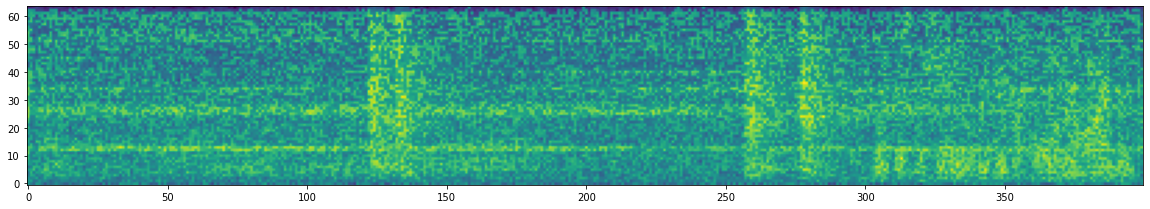

In [43]:

plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [44]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.08161267764328131 0.8446657867579989 1.4337586565485883
 Average | 0.082 | 0.845 | 1.434 
---------+-------+-------+-------
       0 | 0.563 | 0.801 | 1.196 
       1 | 0.007 | 0.670 | 0.622 
       2 | 0.039 | 0.851 | 1.472 
       3 | 0.124 | 0.894 | 1.766 
       4 | 0.067 | 0.934 | 2.136 
       5 | 0.099 | 0.911 | 1.908 
       6 | 0.126 | 0.917 | 1.961 
       7 | 0.181 | 0.948 | 2.296 
       8 | 0.055 | 0.877 | 1.644 
       9 | 0.013 | 0.781 | 1.099 
      10 | 0.027 | 0.801 | 1.196 
      11 | 0.023 | 0.839 | 1.398 
      12 | 0.166 | 0.936 | 2.152 
      13 | 0.087 | 0.902 | 1.832 
      14 | 0.085 | 0.909 | 1.891 
      15 | 0.525 | 0.964 | 2.545 
      16 | 0.063 | 0.827 | 1.331 
      17 | 0.049 | 0.875 | 1.624 
      18 | 0.037 | 0.837 | 1.387 
      19 | 0.051 | 0.774 | 1.066 
      20 | 0.066 | 0.873 | 1.610 
      21 | 0.021 | 

In [46]:
torch.cuda.empty_cache()
perturb = pgd(model, pgd_dataloader, torch.zeros((400,64)).cuda(), num_steps=20, step_size=0.01, step_norm=2, eps= 0.1, eps_norm=2, x_min=np.min(gas_eval_x1), x_max=np.max(gas_eval_x1),delta_min = torch.tensor(np.min(gas_eval_x1) - np.min(gas_eval_x1,axis=0)).cuda(), delta_max = torch.tensor(np.max(gas_eval_x1) - np.max(gas_eval_x1,axis=0)).cuda(), y_target=None )

global loss:6.664766835048795
global loss:6.756830393336713
global loss:6.827206369489431
global loss:6.902606077492237
global loss:6.989640610292554
global loss:7.084245698526502
global loss:7.194087585434318
global loss:7.3089603539556265
global loss:7.446177767589688
global loss:7.569524568505585
global loss:7.704961557872593
global loss:7.836914732120931
global loss:7.975160699337721
global loss:8.117364915087819
global loss:8.260915070772171
global loss:8.384490728378296
global loss:8.52200922369957
global loss:8.64381505921483
global loss:8.769328435882926
global loss:8.877125978469849


In [83]:
new_gas_eval = perturb.cpu().numpy() + gas_eval_x1

In [84]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
#         output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.012540318872514266 0.5973638236871092 0.3486453964945354
 Average | 0.013 | 0.597 | 0.349 
---------+-------+-------+-------
       0 | 0.452 | 0.705 | 0.763 
       1 | 0.003 | 0.535 | 0.126 
       2 | 0.010 | 0.734 | 0.882 
       3 | 0.032 | 0.696 | 0.727 
       4 | 0.019 | 0.808 | 1.233 
       5 | 0.027 | 0.860 | 1.527 
       6 | 0.006 | 0.685 | 0.683 
       7 | 0.019 | 0.798 | 1.180 
       8 | 0.004 | 0.537 | 0.132 
       9 | 0.002 | 0.402 |-0.352 
      10 | 0.003 | 0.438 |-0.221 
      11 | 0.003 | 0.490 |-0.035 
      12 | 0.011 | 0.786 | 1.121 
      13 | 0.002 | 0.424 |-0.272 
      14 | 0.013 | 0.713 | 0.794 
      15 | 0.021 | 0.893 | 1.757 
      16 | 0.019 | 0.756 | 0.983 
      17 | 0.054 | 0.765 | 1.024 
      18 | 0.004 | 0.617 | 0.423 
      19 | 0.009 | 0.665 | 0.603 
      20 | 0.009 | 0.747 | 0.940 
      21 | 0.004 |

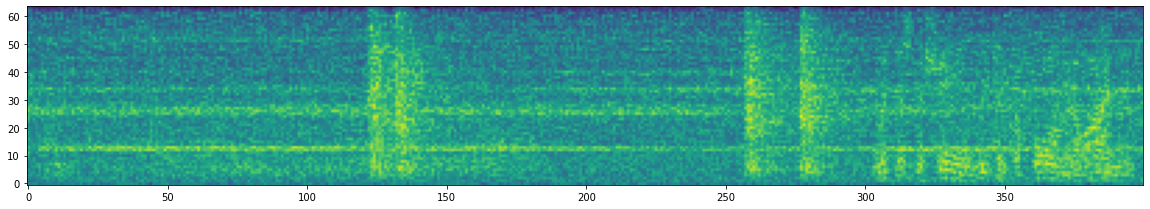

In [85]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

# Strong Label Masking

In [23]:
hf_val_eval_path = os.path.join(local, 'data_64_400_strong_corrected.h5')
mu_val=args.mean
sigma_val=args.std
                            
def bulk_load2(file_path, mu, sigma):
    hf_val_eval = h5py.File(file_path, 'r')
    feat_a = (hf_val_eval['feat_a'][:]*2-mu)/(2 * sigma)
    labels = hf_val_eval['labels'][:]
    hf_val_eval.close()
    return feat_a.astype('float32'), labels.astype('bool')

strong_eval_x1, gas_eval_y = bulk_load2(hf_val_eval_path, mu_val, sigma_val)

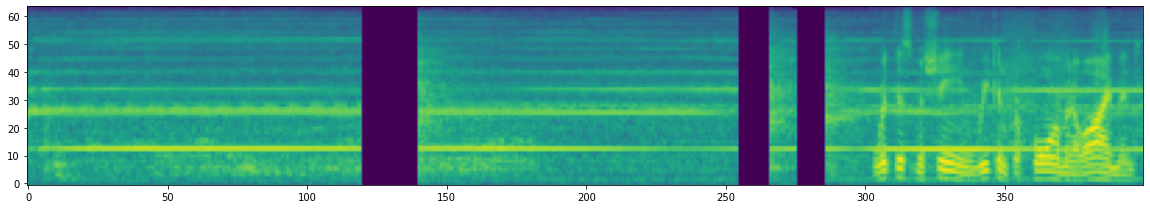

In [24]:
plt.figure(figsize = (20,10))
plt.imshow(strong_eval_x1[1].T, origin='lower')

In [25]:
result = []
batch_size =100
x = strong_eval_x1 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]

total num of batches during testing 202


In [26]:
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.1933270983773672 0.8296278932396925 1.347315344791815
 Average | 0.193 | 0.830 | 1.347 
---------+-------+-------+-------
       0 | 0.602 | 0.787 | 1.124 
       1 | 0.012 | 0.621 | 0.436 
       2 | 0.015 | 0.755 | 0.977 
       3 | 0.180 | 0.857 | 1.506 
       4 | 0.065 | 0.789 | 1.134 
       5 | 0.034 | 0.794 | 1.158 
       6 | 0.249 | 0.931 | 2.092 
       7 | 0.188 | 0.897 | 1.785 
       8 | 0.061 | 0.820 | 1.294 
       9 | 0.040 | 0.807 | 1.223 
      10 | 0.158 | 0.813 | 1.258 
      11 | 0.092 | 0.815 | 1.266 
      12 | 0.228 | 0.616 | 0.418 
      13 | 0.079 | 0.713 | 0.796 
      14 | 0.111 | 0.912 | 1.911 
      15 | 0.334 | 0.945 | 2.266 
      16 | 0.227 | 0.913 | 1.922 
      17 | 0.254 | 0.954 | 2.386 
      18 | 0.147 | 0.925 | 2.034 
      19 | 0.192 | 0.962 | 2.510 
      20 | 0.302 | 0.939 | 2.183 
      21 | 0.110 | 0.922 | 2.003 
      22 | 0.365 | 0.917 | 

# Gaussian Noise Correct from WAV

In [27]:
hf_val_eval_path = os.path.join(local, 'data_64_400_noise0.1.h5')
mu_val=args.mean
sigma_val=args.std
                            
def bulk_load2(file_path, mu, sigma):
    hf_val_eval = h5py.File(file_path, 'r')
    feat_a = (hf_val_eval['feat_a'][:]*2-mu)/(2 * sigma)
    labels = hf_val_eval['labels'][:]
    hf_val_eval.close()
    return feat_a.astype('float32'), labels.astype('bool')

noisy_gas_eval_x1, gas_eval_y = bulk_load2(hf_val_eval_path, mu_val, sigma_val)

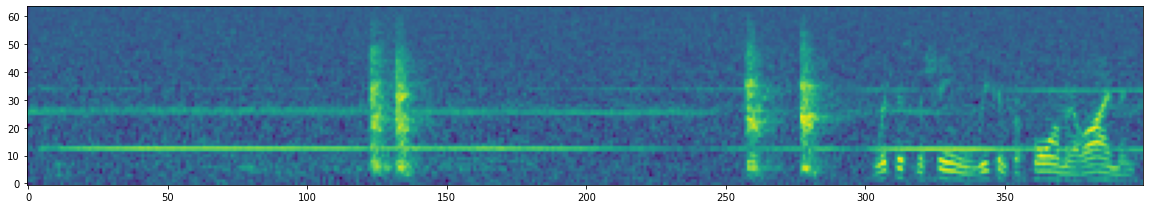

In [28]:
plt.figure(figsize = (20,10))
plt.imshow(noisy_gas_eval_x1[1].T, origin='lower')

In [29]:
result = []
batch_size =100
x = noisy_gas_eval_x1
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]

total num of batches during testing 202


In [30]:
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.15775222373030598 0.8166733544791355 1.2766954186831536
 Average | 0.158 | 0.817 | 1.277 
---------+-------+-------+-------
       0 | 0.640 | 0.854 | 1.492 
       1 | 0.017 | 0.797 | 1.178 
       2 | 0.036 | 0.900 | 1.809 
       3 | 0.231 | 0.929 | 2.079 
       4 | 0.024 | 0.903 | 1.833 
       5 | 0.012 | 0.846 | 1.440 
       6 | 0.085 | 0.873 | 1.613 
       7 | 0.127 | 0.931 | 2.095 
       8 | 0.106 | 0.904 | 1.847 
       9 | 0.063 | 0.899 | 1.807 
      10 | 0.140 | 0.950 | 2.326 
      11 | 0.154 | 0.956 | 2.415 
      12 | 0.797 | 0.995 | 3.610 
      13 | 0.392 | 0.980 | 2.894 
      14 | 0.070 | 0.919 | 1.981 
      15 | 0.002 | 0.152 |-1.453 
      16 | 0.220 | 0.931 | 2.103 
      17 | 0.230 | 0.930 | 2.087 
      18 | 0.074 | 0.928 | 2.070 
      19 | 0.112 | 0.916 | 1.950 
      20 | 0.153 | 0.935 | 2.141 
      21 | 0.033 | 0.881 | 1.666 
      22 | 0.157 | 0.853 